Question 1

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

# Load data
initial_portfolio = pd.read_csv('initial_portfolio.csv')
prices = pd.read_csv('DailyPrices.csv', parse_dates=['Date'])
rf = pd.read_csv('rf.csv', parse_dates=['Date'])

# Process data
prices.set_index('Date', inplace=True)
rf.set_index('Date', inplace=True)

returns = prices.pct_change()

# Merge with risk-free rate
returns = returns.reset_index()
rf = rf.reset_index()
returns_merged = pd.merge_asof(returns.sort_values('Date'),
                             rf.sort_values('Date'),
                             on='Date',
                             direction='backward')
returns_merged.set_index('Date', inplace=True)
returns_merged['rf'] = returns_merged['rf'].ffill()
returns_merged = returns_merged.dropna(subset=returns_merged.columns.difference(['rf']))
returns_merged = returns_merged.dropna(subset=['rf'])
returns = returns_merged

# Split data
estimation_data = returns[returns.index.year <= 2023].copy()
holding_data = returns[returns.index.year > 2023].copy()


market_returns_est = estimation_data['SPY'] - estimation_data['rf']
market_returns_hold = holding_data['SPY'] - holding_data['rf']

# Portfolio processing
portfolio_ids = initial_portfolio['Portfolio'].unique().tolist()
all_symbols_unique = initial_portfolio['Symbol'].unique().tolist()
start_date_prices = prices.loc[prices.index <= '2023-12-31'].iloc[-1]

portfolio_details = {}
total_portfolio_shares = {}

for pid in portfolio_ids:
    pid_str = str(pid)
    df_sub = initial_portfolio[initial_portfolio['Portfolio'] == pid]
    symbols = df_sub['Symbol'].tolist()
    shares = df_sub['Holding'].values


    valid_start_symbols = [s for s in symbols if s in start_date_prices.index and not pd.isna(start_date_prices[s])]
    indices = [symbols.index(s) for s in valid_start_symbols]
    symbols = valid_start_symbols
    shares = shares[indices]

    # Calculate weights
    initial_market_values = shares * start_date_prices[symbols].values
    initial_total_value = initial_market_values.sum()

    if np.isclose(initial_total_value, 0):
        initial_weights = np.ones(len(symbols)) / len(symbols) if len(symbols) > 0 else np.array([])
    else:
        initial_weights = initial_market_values / initial_total_value


    portfolio_details[pid_str] = {
        "symbols": symbols,
        "shares": shares,
        "weights": initial_weights,
        "total_value": initial_total_value
    }

    # Aggregate for total portfolio
    for symbol, share_val in zip(symbols, shares):
        total_portfolio_shares[symbol] = total_portfolio_shares.get(symbol, 0) + share_val

# Process total portfolio
total_symbols = list(total_portfolio_shares.keys())
total_shares = np.array([total_portfolio_shares[s] for s in total_symbols])

valid_total_start_symbols = [s for s in total_symbols if s in start_date_prices.index and not pd.isna(start_date_prices[s])]
if len(valid_total_start_symbols) != len(total_symbols):
    indices = [total_symbols.index(s) for s in valid_total_start_symbols]
    total_symbols = valid_total_start_symbols
    total_shares = total_shares[indices]

if total_symbols:
    total_initial_market_values = total_shares * start_date_prices[total_symbols].values
    total_initial_total_value = total_initial_market_values.sum()

    if np.isclose(total_initial_total_value, 0):
        total_initial_weights = np.ones(len(total_symbols)) / len(total_symbols) if len(total_symbols) > 0 else np.array([])
        print("Warning: Total portfolio initial value is zero. Assigning equal weights.")
    else:
        total_initial_weights = total_initial_market_values / total_initial_total_value

    portfolio_details['Total'] = {
        "symbols": total_symbols,
        "shares": total_shares,
        "weights": total_initial_weights,
        "total_value": total_initial_total_value
    }
else:
    print("Error: Total portfolio has no valid symbols with prices at end 2023. Skipping Total.")
    portfolio_details['Total'] = {"symbols": [], "shares": [], "weights": np.array([]), "total_value": 0.0}

# CAPM Calculation
results_capm_global = {}
relevant_symbols_for_capm = list(portfolio_details['Total']['symbols'])

for sym in relevant_symbols_for_capm:
    if sym == 'SPY':
        results_capm_global[sym] = {'alpha': 0.0, 'beta': 1.0}
        continue

    y_i = estimation_data[sym] - estimation_data['rf']
    df_reg = pd.DataFrame({'y': y_i, 'x': market_returns_est}).dropna()

    y_ = df_reg['y'].values
    x_ = df_reg['x'].values.reshape(-1, 1)
    try:
        reg = LinearRegression().fit(x_, y_)
        alpha = reg.intercept_
        beta = reg.coef_[0]
        results_capm_global[sym] = {'alpha': alpha, 'beta': beta}
    except Exception as e:
        print(f"Error calculating CAPM for {sym}: {e}")
        results_capm_global[sym] = {'alpha': np.nan, 'beta': np.nan}


return_attribution_results = []
risk_attribution_results = []

In [2]:
portfolio_ids = ['A', 'B', 'C', 'Total'] 

for pid in portfolio_ids:
    pid_str = str(pid)
    
    if pid == 'Total':
        # Special handling for Total portfolio
        symbols = portfolio_details['Total']['symbols']
        initial_weights = portfolio_details['Total']['weights']
    else:
        # Regular portfolio handling
        df_sub = initial_portfolio[initial_portfolio['Portfolio'] == pid]
        symbols = df_sub['Symbol'].tolist()
        shares = df_sub['Holding'].values
        
        # Filter symbols with valid prices
        valid_symbols = [s for s in symbols if s in start_date_prices.index and not pd.isna(start_date_prices[s])]
        indices = [symbols.index(s) for s in valid_symbols]
        symbols = valid_symbols
        shares = shares[indices]
        
        # Calculate initial weights
        initial_market_values = shares * start_date_prices[symbols].values
        initial_total_value = initial_market_values.sum()
        
        if np.isclose(initial_total_value, 0):
            initial_weights = np.ones(len(symbols)) / len(symbols) if len(symbols) > 0 else np.array([])
        else:
            initial_weights = initial_market_values / initial_total_value
    
    # Simulate portfolio returns with daily rebalancing
    last_weights = initial_weights.copy()
    port_returns_raw = []
    daily_weights_history = []
    
    holding_data_filtered = holding_data.reindex(columns=symbols + ['rf', 'SPY']).dropna(how='all')
    
    for date in holding_data_filtered.index:
        # Get raw returns for assets in portfolio for the day
        daily_ret_raw = holding_data_filtered.loc[date, symbols].values
        daily_ret_raw[np.isnan(daily_ret_raw)] = 0.0
        
        # Calculate portfolio return for the day based on start-of-day weights
        port_return_t = np.sum(last_weights * daily_ret_raw)
        port_returns_raw.append(port_return_t)
        daily_weights_history.append(last_weights.copy())
        
        # Update weights for next day
        current_values = last_weights * (1 + daily_ret_raw)
        total_value_t = np.sum(current_values)
        last_weights = current_values / total_value_t if not np.isclose(total_value_t, 0) else np.zeros(len(symbols))
    
    # Create aligned time series
    port_ret = pd.Series(port_returns_raw, index=holding_data_filtered.index)
    weights_df = pd.DataFrame(daily_weights_history, columns=symbols, index=holding_data_filtered.index)
    common_index = port_ret.dropna().index
    
    port_ret = port_ret.loc[common_index]
    weights_df = weights_df.loc[common_index]
    market_returns_hold_aligned = market_returns_hold.reindex(common_index).fillna(0)
    rf_hold_aligned = holding_data['rf'].reindex(common_index).fillna(0)
    
    # Decompose returns
    port_sys = []
    port_idio = []
    
    for date in common_index:
        w_t = weights_df.loc[date].values
        r_m_t_excess = market_returns_hold_aligned.loc[date]
        rf_t = rf_hold_aligned.loc[date]
        
        # Compute weighted portfolio beta
        port_beta_t = 0.0
        for i, sym in enumerate(symbols):
            beta_i = results_capm_global.get(sym, {}).get('beta', 0.0)
            if np.isnan(beta_i): 
                beta_i = 0.0
            port_beta_t += w_t[i] * beta_i
        
        # Systematic return = rf + beta * (Rm - Rf)
        sys_t = rf_t + port_beta_t * r_m_t_excess
        ret_t = port_ret.loc[date]
        idio_t = ret_t - sys_t
        
        port_sys.append(sys_t)
        port_idio.append(idio_t)
    
    port_sys = pd.Series(port_sys, index=common_index)
    port_idio = pd.Series(port_idio, index=common_index)
    
    # Carino attribution
    total_return = (1 + port_ret).prod() - 1
    
    if np.isclose(total_return, 0):
        k = 1.0
    elif total_return <= -1.0:
        k = 0.0
    else:
        k = np.log(1 + total_return) / total_return
    
    daily_log_ret = np.log1p(port_ret)
    daily_k_denominator = port_ret * k
    k_t = np.divide(daily_log_ret, daily_k_denominator,
                   out=np.ones_like(daily_log_ret),
                   where=(~np.isclose(daily_k_denominator, 0)))
    k_t = pd.Series(k_t, index=common_index).fillna(1.0)
    
    sys_ret = (port_sys * k_t).sum()
    idio_ret = (port_idio * k_t).sum()
    
    # Risk Attribution
    p_tot = port_ret.fillna(0)
    p_sys = port_sys.fillna(0)
    p_idio = port_idio.fillna(0)
    
    total_vol = p_tot.std(ddof=0)
    
    if len(p_tot) > 1 and not np.isclose(total_vol, 0):
        sys_cov = np.cov(p_sys, p_tot, ddof=0)[0, 1]
        idio_cov = np.cov(p_idio, p_tot, ddof=0)[0, 1]
        
        sys_risk = sys_cov / total_vol
        idio_risk = idio_cov / total_vol
    else:
        sys_risk = 0.0
        idio_risk = 0.0
    
    expected_idio_risk = p_idio.std(ddof=0)
    
    # === Output Section ===
    print(f"\nPortfolio {pid} Attribution Summary")
    print(f"{'Metric':<30} {'Value':>12}")
    print("-" * 45)
    print(f"{'Total Return':<30} {total_return:>12.6f}")
    print(f"{'Systematic Return':<30} {sys_ret:>12.6f}")
    print(f"{'Idiosyncratic Return':<30} {idio_ret:>12.6f}")
    print("-" * 45)
    print(f"{'Total Risk (Daily)':<30} {total_vol:>12.6f}")
    print(f"{'Systematic Risk':<30} {sys_risk:>12.6f}")
    print(f"{'Idiosyncratic Risk':<30} {idio_risk:>12.6f}")
    print(f"{'Expected Idio Risk':<30} {expected_idio_risk:>12.6f}")


Portfolio A Attribution Summary
Metric                                Value
---------------------------------------------
Total Return                       0.136642
Systematic Return                  0.243361
Idiosyncratic Return              -0.106719
---------------------------------------------
Total Risk (Daily)                 0.007404
Systematic Risk                    0.007056
Idiosyncratic Risk                 0.000348
Expected Idio Risk                 0.003293

Portfolio B Attribution Summary
Metric                                Value
---------------------------------------------
Total Return                       0.203526
Systematic Return                  0.238964
Idiosyncratic Return              -0.035438
---------------------------------------------
Total Risk (Daily)                 0.006854
Systematic Risk                    0.006414
Idiosyncratic Risk                 0.000440
Expected Idio Risk                 0.003370

Portfolio C Attribution Summary
Metric       

Question 2: 

In [3]:
import pandas as pd, numpy as np, warnings, time, inspect
from scipy import stats
warnings.filterwarnings('ignore')

# ────────────────────────────── CONSTANTS ──────────────────────────────────
ALPHA         = 0.05          # 95 % confidence
N_SIMULATIONS = 10_000
np.random.seed(42)

# ────────────────────────────── 1. Load Data ───────────────────────────────
init_port = pd.read_csv('initial_portfolio.csv')
prices    = pd.read_csv('DailyPrices.csv', parse_dates=['Date']).set_index('Date')
rf        = pd.read_csv('rf.csv',          parse_dates=['Date']).set_index('Date')

returns = prices.pct_change().reset_index()
rf      = rf.reset_index()
returns = pd.merge_asof(returns.sort_values('Date'),
                        rf.sort_values('Date'),
                        on='Date', direction='backward')
returns.set_index('Date', inplace=True)
returns['rf'] = returns['rf'].ffill()

est_ret = returns[returns.index.year <= 2023].drop(columns=['rf'], errors='ignore')
symbols = [s for s in init_port['Symbol'].unique() if s in est_ret.columns]

# ─────────────────────── 2. Fit Marginal Distributions ─────────────────────
print("\n## Fitting distributions")
dists = {'Normal': stats.norm,
         'Gen T': stats.t,
         'NIG': stats.norminvgauss,
         'SkewNorm': stats.skewnorm}

best_model, ppf_cache = {}, {}
for sym in symbols:
    x  = est_ret[sym].dropna().values
    n  = len(x)
    best_aicc, best_name, best_par = np.inf, None, None

    for name, dist in dists.items():
        pars = dist.fit(x, floc=0) if name in ('Normal', 'SkewNorm') else dist.fit(x)
        k    = len(pars) - (1 if name in ('Normal', 'SkewNorm') else 0)
        ll   = dist.logpdf(x, *pars).sum()
        aicc = 2*k - 2*ll + (2*k**2 + 2*k) / (n - k - 1)
        if aicc < best_aicc: best_aicc, best_name, best_par = aicc, name, pars

    p    = list(best_par)
    loc  = len(dists[best_name].shapes.split(',')) if dists[best_name].shapes else 0
    p[loc] = 0.0
    best_model[sym] = {'dist': dists[best_name], 'pars': tuple(p)}
    print(f"  {sym}: {best_name:8s}  AICc={best_aicc:8.2f}")

    u        = np.linspace(0.001, 0.999, 1000)
    ppf_cache[sym] = {'u': u, 'ppf': dists[best_name].ppf(u, *p)}

# ─────────────────── 3. Build Portfolios & Initial Weights ──────────────────
port_defs, port_w, port_val = {}, {}, {}
t0_price = prices.loc[prices.index <= pd.Timestamp('2023-12-31')].iloc[-1]

def _weights(symbols, shares):
    mv = np.array([q*t0_price[s] for s, q in zip(symbols, shares)])
    return mv/mv.sum() if mv.sum() else np.ones(len(mv))/len(mv)

for pid in init_port['Portfolio'].unique():
    rows   = init_port[init_port['Portfolio']==pid]
    syms   = [s for s in rows['Symbol'] if s in best_model]
    shares = rows.set_index('Symbol').loc[syms,'Holding'].values
    w      = _weights(syms, shares)
    port_defs[str(pid)] = syms
    port_w[str(pid)]    = pd.Series(w, index=syms)
    port_val[str(pid)]  = (w*t0_price[syms].values*shares.sum()).sum()

tot = init_port.groupby('Symbol')['Holding'].sum()
syms = [s for s in tot.index if s in best_model]
w    = _weights(syms, tot[syms].values)
port_defs['Total'] = syms
port_w['Total']    = pd.Series(w, index=syms)
port_val['Total']  = (w*t0_price[syms].values*tot[syms].values.sum()).sum()

print("\n## Portfolio overview")
for p,s in port_defs.items():
    print(f"  {p:>6}: {len(s):3d} assets  value ${port_val[p]:,.2f}")

# ────────────────────── helper: VaR & ES from array ─────────────────────────
def _var_es(r, a=ALPHA):
    r = np.sort(r)
    i = int(a*len(r))
    return -r[i], -r[:i+1].mean()

# ─────────────────────── 4. Risk Metrics per Portfolio ──────────────────────
print(f"\n## 1‑Day 95 % VaR & ES (USD)")
results = []
for p, syms in port_defs.items():
    if not syms: continue
    w = port_w[p].values
    est = est_ret[syms].dropna()
    if est.empty: continue

    R = est.corr(method='spearman').fillna(0).values + np.eye(len(syms))*1e-10
    Z = np.random.randn(N_SIMULATIONS, len(syms)) @ np.linalg.cholesky(R).T
    U = stats.norm.cdf(Z)
    X = np.column_stack([
            np.interp(U[:,i], ppf_cache[s]['u'], ppf_cache[s]['ppf'])
            for i,s in enumerate(syms)])
    cop_var, cop_es = _var_es(X @ w)

    cov   = est.cov().values
    std_p = np.sqrt(np.dot(w, cov @ w))
    z     = stats.norm.ppf(ALPHA)
    mvn_var = -z * std_p
    mvn_es  = -(std_p * stats.norm.pdf(z)/ALPHA)

    results.append({
        'Portfolio': p,
        'Value($)': port_val[p],
        'VaR_Cop$': cop_var*port_val[p],
        'ES_Cop$':  cop_es*port_val[p],
        'VaR_MVN$': mvn_var*port_val[p],
        'ES_MVN$':  mvn_es*port_val[p],
        'VaR_Cop%': cop_var*100,
        'ES_Cop%':  cop_es*100,
        'VaR_MVN%': mvn_var*100,
        'ES_MVN%':  mvn_es*100
    })

# ───────────────────────── 5. Print Summaries (USD) ─────────────────────────
if results:
    for r in results:
        var_diff = (r['VaR_Cop%'] - r['VaR_MVN%']) / r['VaR_MVN%'] * 100
        es_diff  = (r['ES_Cop%']  - r['ES_MVN%'])  / r['ES_MVN%']  * 100

        print(f"\n Portfolio {r['Portfolio']}")
        print(f"   Size         : ${r['Value($)']:,.2f}")
        print(f"   Copula VaR   : ${r['VaR_Cop$']:,.2f}")
        print(f"   Copula ES    : ${r['ES_Cop$']:,.2f}")
        print(f"   MVN VaR      : ${r['VaR_MVN$']:,.2f}")
        print(f"   MVN ES       : ${r['ES_MVN$']:,.2f}")
        print(f"   Δ VaR (Cop‑MVN): {var_diff:+.2f}%")
        print(f"   Δ ES  (Cop‑MVN): {es_diff:+.2f}%")
        print("   " + "-"*42)
else:
    print("No results produced.")


## Fitting distributions
  WFC: Gen T     AICc=-1320.37
  ETN: Gen T     AICc=-1353.58
  AMZN: Gen T     AICc=-1232.15
  QCOM: Gen T     AICc=-1259.42
  LMT: Gen T     AICc=-1589.31
  KO: Gen T     AICc=-1690.34
  JNJ: Gen T     AICc=-1611.97
  ISRG: Gen T     AICc=-1311.49
  XOM: Gen T     AICc=-1363.94
  MDT: Gen T     AICc=-1448.71
  DHR: Gen T     AICc=-1395.12
  PLD: Gen T     AICc=-1337.94
  BA: Gen T     AICc=-1335.71
  PG: Gen T     AICc=-1625.03
  MRK: Gen T     AICc=-1501.28
  AMD: Gen T     AICc=-1062.75
  BX: Gen T     AICc=-1200.40
  PM: Gen T     AICc=-1570.04
  SCHW: Gen T     AICc=-1164.07
  VZ: Gen T     AICc=-1465.94
  COP: Gen T     AICc=-1307.26
  ADI: Gen T     AICc=-1348.73
  BAC: Gen T     AICc=-1338.24
  NOW: NIG       AICc=-1259.27
  TMO: Gen T     AICc=-1415.77
  CVX: Gen T     AICc=-1418.55
  ANET: Gen T     AICc=-1166.37
  NVDA: Gen T     AICc=-1086.71
  GE: NIG       AICc=-1381.76
  GILD: Gen T     AICc=-1464.27
  MU: NIG       AICc=-1194.58
  CMCSA: Gen T

Question 3: 

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


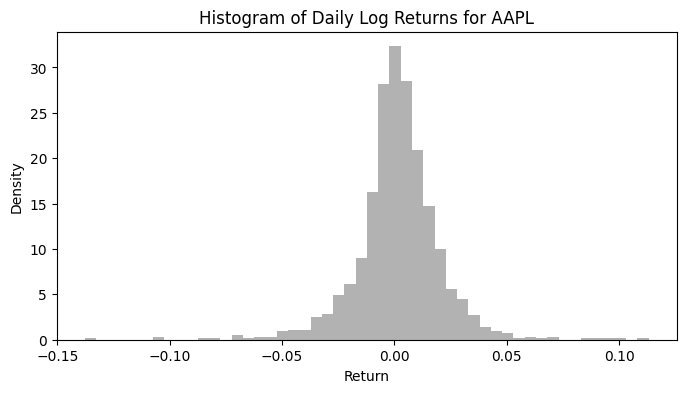

Skew-Normal params: (np.float64(-1.0090956245133753), np.float64(0.014502323409388604), np.float64(0.023187897755110792))
NIG params: [ 3.54949829e+01 -6.91804087e-01  1.29006902e-02  1.83397216e-03]


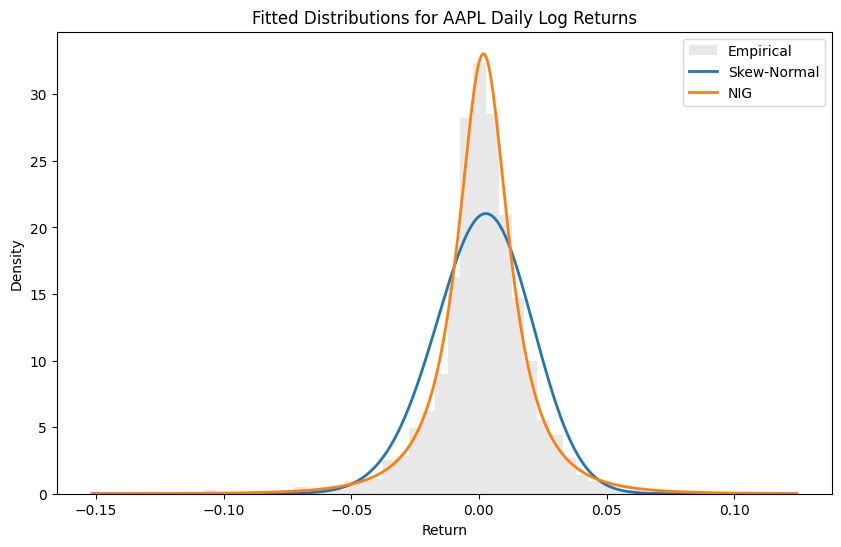


VaR (Daily) estimates:
Skew-Normal VaR: {'VaR_95%': np.float64(-0.03064299893205558), 'VaR_99%': np.float64(-0.04532173990091404)}
NIG VaR: {'VaR_95%': np.float64(-0.02772431571765663), 'VaR_99%': np.float64(-0.05340700884092421)}


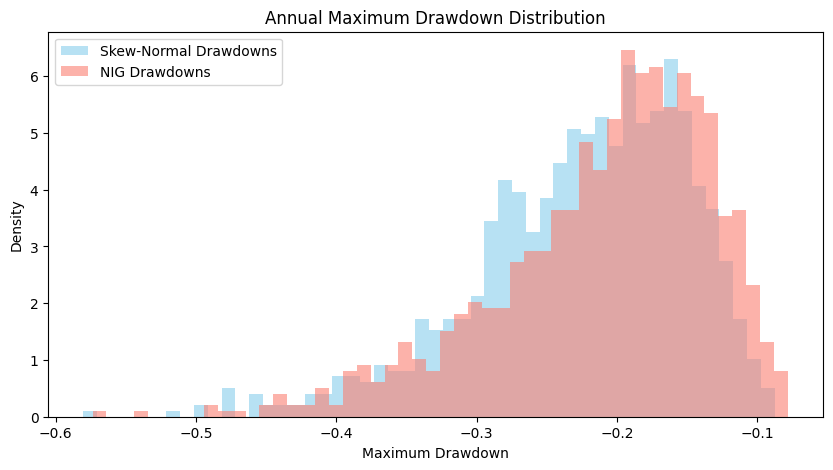


Drawdown Summary:
Skew-Normal: Mean = -22.49%, 5th percentile = -36.89%
NIG: Mean = -20.92%, 5th percentile = -36.24%


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skewnorm
from scipy.optimize import minimize
from scipy.special import k1
import yfinance as yf

# Data Loading and Processing
ticker = "AAPL"
data = yf.download(ticker, start="2017-01-01", end="2022-01-01")['Close'].dropna()
returns = np.log(data / data.shift(1)).dropna()
ret_values = returns.values

plt.figure(figsize=(8, 4))
plt.hist(ret_values, bins=50, density=True, alpha=0.6, color='grey')
plt.title(f"Histogram of Daily Log Returns for {ticker}")
plt.xlabel("Return")
plt.ylabel("Density")
plt.show()

# Skew-Normal Fit
sn_params = skewnorm.fit(ret_values)
sn_shape, sn_loc, sn_scale = sn_params
print("Skew-Normal params:", sn_params)
x_vals = np.linspace(ret_values.min()*1.1, ret_values.max()*1.1, 500)
sn_pdf = skewnorm.pdf(x_vals, sn_shape, loc=sn_loc, scale=sn_scale)

# NIG Fit
def nig_pdf(x, alpha, beta, delta, mu):
    sqrt_term = np.sqrt(delta**2 + (x - mu)**2)
    return (alpha * delta / np.pi) * np.exp(delta * np.sqrt(alpha**2 - beta**2) + beta * (x - mu)) * k1(alpha * sqrt_term) / sqrt_term

def nig_neg_log_likelihood(params, data):
    alpha, beta, delta, mu = params
    if alpha <= 0 or delta <= 0 or np.abs(beta) >= alpha:
        return 1e6
    pdf_vals = nig_pdf(data, alpha, beta, delta, mu)
    if np.any(pdf_vals <= 0):
        return 1e6
    return -np.sum(np.log(pdf_vals))

init_params = [10, 0, np.std(ret_values), np.mean(ret_values)]
bounds = [(1e-3, None), (None, None), (1e-3, None), (None, None)]
res = minimize(nig_neg_log_likelihood, init_params, args=(ret_values,), method='L-BFGS-B', bounds=bounds)
nig_params = res.x
print("NIG params:", nig_params)
nig_pdf_vals = nig_pdf(x_vals, *nig_params)

plt.figure(figsize=(10, 6))
plt.hist(ret_values, bins=50, density=True, alpha=0.5, color='lightgrey', label="Empirical")
plt.plot(x_vals, sn_pdf, label="Skew-Normal", lw=2)
plt.plot(x_vals, nig_pdf_vals, label="NIG", lw=2)
plt.title(f"Fitted Distributions for {ticker} Daily Log Returns")
plt.xlabel("Return")
plt.ylabel("Density")
plt.legend()
plt.show()

# Monte Carlo Simulations and VaR
n_simulations = 100000
simulated_sn = skewnorm.rvs(sn_shape, loc=sn_loc, scale=sn_scale, size=n_simulations)

def simulate_nig(alpha, beta, delta, mu, size=1):
    gamma = np.sqrt(alpha**2 - beta**2)
    mu_inv = delta / gamma
    lambda_inv = delta**2
    Y = np.random.normal(size=size)**2
    V_candidate = mu_inv + (mu_inv**2 * Y) / (2 * lambda_inv) - (mu_inv / (2 * lambda_inv)) * np.sqrt(4 * mu_inv * lambda_inv * Y + (mu_inv**2) * Y**2)
    U = np.random.uniform(size=size)
    V = np.where(U <= mu_inv / (mu_inv + V_candidate), V_candidate, (mu_inv**2) / V_candidate)
    Z = np.random.normal(size=size)
    return mu + beta * V + np.sqrt(V) * Z

simulated_nig = simulate_nig(*nig_params, size=n_simulations)
var_levels = [5, 1]
sn_var = {f"VaR_{100 - level}%": np.percentile(simulated_sn, level) for level in var_levels}
nig_var = {f"VaR_{100 - level}%": np.percentile(simulated_nig, level) for level in var_levels}
print("\nVaR (Daily) estimates:")
print("Skew-Normal VaR:", sn_var)
print("NIG VaR:", nig_var)

# Scenario Analysis: Annual Paths and Drawdowns
def simulate_paths(sim_func, params, n_paths=1000, n_days=252):
    paths = np.zeros((n_paths, n_days))
    for i in range(n_paths):
        daily_returns = sim_func(*params, size=n_days) if params is not None else sim_func(size=n_days)
        paths[i] = np.cumprod(1 + daily_returns)
    return paths

simulate_skewnorm = lambda size: skewnorm.rvs(sn_shape, loc=sn_loc, scale=sn_scale, size=size)
paths_sn = simulate_paths(simulate_skewnorm, None, n_paths=1000, n_days=252)
paths_nig = simulate_paths(simulate_nig, nig_params, n_paths=1000, n_days=252)

def max_drawdown(path):
    peak = np.maximum.accumulate(path)
    return ((path - peak) / peak).min()

drawdowns_sn = np.array([max_drawdown(path) for path in paths_sn])
drawdowns_nig = np.array([max_drawdown(path) for path in paths_nig])

plt.figure(figsize=(10, 5))
plt.hist(drawdowns_sn, bins=50, alpha=0.6, label='Skew-Normal Drawdowns', color='skyblue', density=True)
plt.hist(drawdowns_nig, bins=50, alpha=0.6, label='NIG Drawdowns', color='salmon', density=True)
plt.xlabel("Maximum Drawdown")
plt.ylabel("Density")
plt.title("Annual Maximum Drawdown Distribution")
plt.legend()
plt.show()

print("\nDrawdown Summary:")
print("Skew-Normal: Mean = {:.2%}, 5th percentile = {:.2%}".format(np.mean(drawdowns_sn), np.percentile(drawdowns_sn, 5)))
print("NIG: Mean = {:.2%}, 5th percentile = {:.2%}".format(np.mean(drawdowns_nig), np.percentile(drawdowns_nig, 5)))


Question 4:

In [5]:
import pandas as pd, numpy as np, warnings
from scipy import stats, interpolate
warnings.filterwarnings('ignore')

ALPHA, N_SIM = 0.05, 50_000 # 95 % confidence, 50000 simulations due to 100+ stocks
np.random.seed(42)

# ───────── 0. load data ────────────────────────────────────────────────────
init = pd.read_csv("initial_portfolio.csv")
prices = pd.read_csv("DailyPrices.csv", parse_dates=["Date"]).set_index("Date")
rf     = pd.read_csv("rf.csv",         parse_dates=["Date"]).set_index("Date")

returns = prices.pct_change().reset_index()
returns = pd.merge_asof(returns.sort_values("Date"),
                        rf.reset_index().sort_values("Date"),
                        on="Date", direction="backward")
returns.set_index("Date", inplace=True)
returns["rf"] = returns["rf"].ffill()

est_ret = returns[returns.index.year <= 2023].drop(columns=["rf"], errors="ignore")
symbols = [s for s in init["Symbol"].unique() if s in est_ret.columns]

# ───────── 1. fit marginal distributions ──────────────────────────────────
print("\n## marginal fits (assume 0 % mean)")
dmap = {"Normal": stats.norm,
        "StudentT": stats.t,
        "NIG": stats.norminvgauss,
        "SkewNorm": stats.skewnorm}

best_fit, ppf_cache = {}, {}
u_grid = np.linspace(0.001, 0.999, 1_000)

for sym in symbols:
    x, n = est_ret[sym].dropna().values, len(est_ret)
    best_aicc = np.inf
    for name, dist in dmap.items():
        pars = dist.fit(x, floc=0) if name in ("Normal", "SkewNorm") else dist.fit(x)
        k    = len(pars) - (1 if name in ("Normal", "SkewNorm") else 0)
        ll   = dist.logpdf(x, *pars).sum()
        aic  = 2*k - 2*ll
        aicc = aic if n - k - 1 <= 0 else aic + (2*k*(k+1))/(n-k-1)
        if aicc < best_aicc:
            best_aicc, best_name, best_pars = aicc, name, pars
    pars = list(best_pars)
    loc  = len(dmap[best_name].shapes.split(',')) if dmap[best_name].shapes else 0
    pars[loc] = 0.0
    pars = tuple(pars)
    best_fit[sym] = {"dist": dmap[best_name], "pars": pars}
    print(f"{sym:<6} ▸ {best_name:<9}  AICc={best_aicc:8.2f}  pars={np.round(pars,4)}")
    ppf_cache[sym] = interpolate.interp1d(
        u_grid, dmap[best_name].ppf(u_grid, *pars),
        kind="linear", assume_sorted=True, copy=False)

# ───────── 2. build each portfolio (weights & value) ───────────────────────
portfolio_ids = init["Portfolio"].unique()
port_defs, port_w, port_val = {}, {}, {}
t0_price = prices.loc[prices.index <= pd.Timestamp("2023-12-31")].iloc[-1]

def make_port(df):
    mv = df["Holding"].values * t0_price[df["Symbol"]].values
    w  = mv / mv.sum() if mv.sum() else np.ones(len(mv)) / len(mv)
    return df["Symbol"].tolist(), w, mv.sum()

for pid in portfolio_ids:
    syms, w, pv = make_port(init[init["Portfolio"] == pid]
                            .query("Symbol in @best_fit.keys()"))
    port_defs[str(pid)], port_w[str(pid)], port_val[str(pid)] = syms, w, pv

# ───────── 2.a loop to build TOTAL portfolio ─────────
all_portfolio_symbols = []
for pid in portfolio_ids:
    all_portfolio_symbols.extend(
        init[init['Portfolio'] == pid]['Symbol'].tolist())

all_portfolio_symbols = list(set(
    [s for s in all_portfolio_symbols if s in best_fit.keys()]))

total_holdings = {}
for pid in portfolio_ids:
    df_sub = init[init['Portfolio'] == pid]
    for _, row in df_sub.iterrows():
        symbol = row['Symbol']
        if symbol in best_fit.keys():
            if symbol not in total_holdings:
                total_holdings[symbol] = 0
            total_holdings[symbol] += row['Holding']

total_market_values, total_symbols = [], []
for symbol, shares in total_holdings.items():
    if symbol in t0_price.index and not pd.isna(t0_price[symbol]):
        total_market_values.append(shares * t0_price[symbol])
        total_symbols.append(symbol)

total_market_values = np.array(total_market_values)
total_portfolio_value = total_market_values.sum()
total_weights = (total_market_values /
                 total_portfolio_value if total_portfolio_value else
                 np.ones(len(total_market_values)) / len(total_market_values))

port_defs['Total'] = total_symbols
port_w['Total']    = pd.Series(total_weights, index=total_symbols).values
port_val['Total']  = total_portfolio_value

# ───────── 3. overview ─────────────────────────────────────────────────────
print("\n## portfolios")
for pid in port_defs:
    print(f"{pid:>6}: {len(port_defs[pid])} assets  value ${port_val[pid]:,.2f}")

# ───────── helper: VaR / ES ────────────────────────────────────────────────
def var_es(r):
    r_sorted = np.sort(r)
    idx = int(ALPHA * len(r))
    return -r_sorted[idx], -r_sorted[:idx+1].mean()

# ───────── 4. risk metrics ─────────────────────────────────────────────────
results = []
for pid, syms in port_defs.items():
    if not syms: continue
    w = port_w[pid]
    est = est_ret[syms].dropna()
    if est.empty: continue

    R = est.corr("spearman").fillna(0).values + np.eye(len(syms))*1e-10
    Z = np.random.standard_normal((N_SIM, len(syms))) @ np.linalg.cholesky(R).T
    U = stats.norm.cdf(Z)
    X = np.column_stack(
        [ppf_cache[s](np.clip(U[:, i], 0.001, 0.999)) for i, s in enumerate(syms)])
    cop_var, cop_es = var_es(X @ w)

    cov = est.cov().values
    sd  = np.sqrt(w @ cov @ w)
    z   = stats.norm.ppf(ALPHA)
    mvn_var = -z * sd
    mvn_es  = -(sd * stats.norm.pdf(z) / ALPHA)

    results.append({
        "pid": pid,
        "value": port_val[pid],
        "VaR_c": cop_var * port_val[pid],
        "ES_c":  cop_es  * port_val[pid],
        "VaR_m": mvn_var * port_val[pid],
        "ES_m":  mvn_es  * port_val[pid],
        "dVaR":  (cop_var-mvn_var)/mvn_var*100,
        "dES":   (cop_es -mvn_es )/mvn_es *100
    })

# ───────── 5. narrative output & discussion ────────────────────────────────
for r in results:
    print(f"\n Portfolio {r['pid']}")
    print(f"   value      : ${r['value']:,.2f}")
    print(f"   Copula VaR : ${r['VaR_c']:,.2f}")
    print(f"   Copula ES  : ${r['ES_c']:,.2f}")
    print(f"   MVN VaR    : ${r['VaR_m']:,.2f}")
    print(f"   MVN ES     : ${r['ES_m']:,.2f}")
    print(f"   ΔVaR (c‑m) : {r['dVaR']:+.2f}%")
    print(f"   ΔES  (c‑m) : {r['dES']:+.2f}%")
    print("   " + "-"*42)


## marginal fits (assume 0 % mean)
WFC    ▸ StudentT   AICc=-1320.37  pars=[5.0037 0.     0.0137]
ETN    ▸ StudentT   AICc=-1353.58  pars=[3.8783 0.     0.012 ]
AMZN   ▸ StudentT   AICc=-1232.15  pars=[5.9219 0.     0.0169]
QCOM   ▸ StudentT   AICc=-1259.42  pars=[5.2207 0.     0.0156]
LMT    ▸ StudentT   AICc=-1589.31  pars=[3.7033 0.     0.0074]
KO     ▸ StudentT   AICc=-1690.34  pars=[5.2155 0.     0.0066]
JNJ    ▸ StudentT   AICc=-1611.98  pars=[3.605 0.    0.007]
ISRG   ▸ StudentT   AICc=-1311.49  pars=[4.7002 0.     0.0137]
XOM    ▸ StudentT   AICc=-1363.94  pars=[7.8807 0.     0.0136]
MDT    ▸ StudentT   AICc=-1448.71  pars=[4.583  0.     0.0104]
DHR    ▸ StudentT   AICc=-1395.12  pars=[5.3055 0.     0.0119]
PLD    ▸ StudentT   AICc=-1337.94  pars=[6.6757 0.     0.0139]
BA     ▸ StudentT   AICc=-1335.71  pars=[4.703  0.     0.0131]
PG     ▸ StudentT   AICc=-1625.04  pars=[5.5198 0.     0.0076]
MRK    ▸ StudentT   AICc=-1501.28  pars=[8.0684 0.     0.0103]
AMD    ▸ StudentT   AI

Question 5: 

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats

ALPHA_RP = 0.05          # 95 % ES
N_SIM_RP = 1_000_000     # Monte‑Carlo draws for the copula
np.random.seed(42)

# ───────────────── 1. Simulate asset returns from Gaussian copula ───────────
def simulate_asset_returns(symbols, corr, ppf_cache, n_sim=N_SIM_RP):
    L = np.linalg.cholesky(corr + np.eye(len(symbols)) * 1e-12)
    Z = np.random.standard_normal((n_sim, len(symbols))) @ L.T
    U = stats.norm.cdf(Z)                                 # uniform(0,1)

    cols = []
    for i, s in enumerate(symbols):
        cache = ppf_cache[s]
        u_vec = np.clip(U[:, i], 0.001, 0.999)            # avoid extrapolation
        if isinstance(cache, dict):                       # Part 2 structure
            vals = np.interp(u_vec, cache["u"], cache["ppf"])
        else:                                             # Part 4 interp1d
            vals = cache(u_vec)
        cols.append(vals)

    return np.column_stack(cols)                          # shape (n_sim, d)

# ───────────────── 2. ES and component‑ES helpers ───────────────────────────
def es_components(weights, sim, alpha=ALPHA_RP):
    w = np.asarray(weights, float)
    port_ret = sim @ w
    threshold = np.quantile(port_ret, alpha)
    tail = sim[port_ret <= threshold]                     # worst alpha %
    marg_es = -tail.mean(axis=0)                          # marginal ES_i
    comp_es = w * marg_es                                 # component ES_i
    return -tail.mean(), comp_es

# ───────────────── 3. Closed‑form iterative risk budgeting (Spinu 2013) ─────
def risk_parity_es(sim, w_init=None, alpha=ALPHA_RP,
                   tol=1e-12, max_iter=200):
    n = sim.shape[1]
    w = np.ones(n) / n if w_init is None else w_init / w_init.sum()

    for _ in range(max_iter):
        _, comp = es_components(w, sim, alpha)            # component ES
        m_es = np.divide(comp, w, where=w > 0)            # marginal ES
        w_new = 1.0 / m_es                                # proportional update
        w_new /= w_new.sum()                              # renormalise

        if np.max(np.abs(w_new - w)) < tol:
            return w_new
        w = w_new

    return w                                              # return last iterate

# ───────────────── 4. Build risk‑parity weights for each sub‑portfolio ───────
rp_weights = {}   # {pid: pd.Series}

for pid, syms in port_defs.items():
    if not syms:                                           # skip empty
        continue

    # simulate joint distribution
    est = est_ret[syms].dropna()
    corr = est.corr("spearman").fillna(0).values
    sim = simulate_asset_returns(syms, corr, ppf_cache, n_sim=N_SIM_RP)

    # iterative risk budgeting
    w0 = np.asarray(port_w[pid])                           # cap‑weighted start
    w_rp = risk_parity_es(sim, w_init=w0)

    # store
    rp_weights[pid] = pd.Series(w_rp, index=syms)

    # quick convergence check
    _, c_es = es_components(w_rp, sim)
    max_dev = np.abs(c_es / c_es.mean() - 1).max()
    print(f"[{pid}] max relative deviation in ES budget = {max_dev:.3%}")

# ───────────────── 5. Carino attribution using new weights ───────────────────
def carino_attribution(pid, init_w, symbols,
                       beta_map, returns_all):
    hold = returns_all[returns_all.index.year > 2023]
    cols = symbols + ["SPY", "rf"]
    df_h = hold.reindex(columns=cols).dropna(how="all")

    w_t = init_w.copy()
    p_ret, sys_ret, id_ret = [], [], []

    for _, row in df_h.iterrows():
        r_vec = row[symbols].fillna(0.0).values
        port_r = (w_t * r_vec).sum()
        p_ret.append(port_r)

        beta_p = sum(
            w * beta_map.get(s, {}).get("beta", 0.0)
            for s, w in zip(symbols, w_t)
        )
        sys_t = row["rf"] + beta_p * (row["SPY"] - row["rf"])
        sys_ret.append(sys_t)
        id_ret.append(port_r - sys_t)

        w_t = w_t * (1 + r_vec)
        w_t /= w_t.sum() if w_t.sum() else 1.0

    # series
    p_ret = pd.Series(p_ret, index=df_h.index)
    sys_ret = pd.Series(sys_ret, index=df_h.index)
    id_ret = pd.Series(id_ret, index=df_h.index)

    # Carino scaling
    tot_R = (1 + p_ret).prod() - 1
    k = 1.0 if np.isclose(tot_R, 0) else np.log1p(tot_R) / tot_R
    k_t = np.log1p(p_ret) / (p_ret * k)
    k_t.replace([np.inf, -np.inf], 1.0, inplace=True)

    # returns
    R_sys = (sys_ret * k_t).sum()
    R_id = (id_ret * k_t).sum()

    # risks
    vol = p_ret.std(ddof=0)
    sys_cov = np.cov(sys_ret, p_ret, ddof=0)[0, 1] if len(p_ret) > 1 else 0.0
    id_cov = np.cov(id_ret, p_ret, ddof=0)[0, 1] if len(p_ret) > 1 else 0.0
    sys_risk = sys_cov / vol if vol else 0.0
    id_risk = id_cov / vol if vol else 0.0

    return {
        "Total Return": tot_R,
        "Systematic Return": R_sys,
        "Idiosyncratic Return": R_id,
        "Total Risk (Daily)": vol,
        "Systematic Risk": sys_risk,
        "Idiosyncratic Risk": id_risk,
    }

print("\n##  Carino Attribution on ES‑Risk‑Parity Portfolios")
attrib_rp = {}
for pid, syms in port_defs.items():
    if not syms:
        continue
    metrics = carino_attribution(
        pid,
        rp_weights[pid].values,
        syms,
        results_capm_global,
        returns,
    )
    attrib_rp[pid] = metrics

    print(f"\nPortfolio {pid}")
    for k, v in metrics.items():
        print(f"  {k:<25} {v:>12.6f}")


[A] max relative deviation in ES budget = 0.167%
[B] max relative deviation in ES budget = 0.007%
[C] max relative deviation in ES budget = 0.008%
[Total] max relative deviation in ES budget = 0.017%

##  Carino Attribution on ES‑Risk‑Parity Portfolios

Portfolio A
  Total Return                  0.213120
  Systematic Return             0.226306
  Idiosyncratic Return         -0.013186
  Total Risk (Daily)            0.007061
  Systematic Risk               0.005869
  Idiosyncratic Risk            0.001192

Portfolio B
  Total Return                  0.249598
  Systematic Return             0.225389
  Idiosyncratic Return          0.024210
  Total Risk (Daily)            0.006433
  Systematic Risk               0.005568
  Idiosyncratic Risk            0.000864

Portfolio C
  Total Return                  0.315417
  Systematic Return             0.242246
  Idiosyncratic Return          0.073172
  Total Risk (Daily)            0.007530
  Systematic Risk               0.006509
  Idiosyncr

In [21]:
for pid in ['A','B','C']:
    syms = port_defs[pid]
    sim  = simulate_asset_returns(syms,
                                  est_ret[syms].corr('spearman').values,
                                  ppf_cache, n_sim=200_000)
    es, comp = es_components(rp_weights[pid], sim)
    print(pid, np.round(comp / comp.mean() - 1, 3).max())

A 0.025
B 0.015
C 0.022
